In [1]:
# Usage guide:

# This document is not kept on record. If the calcualtions are to be kept,
# copy the whole notebook and put it in "quick_calculations" or appropriate
# folders.

In [2]:
# import all the E9 stuff
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import time

# User defined modules
E9path = Path("C:/", "Users", "ken92", "Documents", "Studies", "E5", "simulation", "E9_simulations")
if str(E9path) not in sys.path:
    sys.path.insert(1, str(E9path))
import E9_fn.E9_constants as E9c
import E9_fn.E9_atom as E9a
import E9_fn.E9_cooltrap as E9ct
import E9_fn.plane_wave_expansion.blochstate_class as bsc
import E9_fn.polarizabilities_calculation as E9pol
# import E9_fn.datasets.transition_line_data as TLData
from E9_fn import util

# Logging
logpath = '' # '' if not logging to a file
loglevel = logging.INFO
logroot = logging.getLogger()
list(map(logroot.removeHandler, logroot.handlers))
list(map(logroot.removeFilter, logroot.filters))
logging.basicConfig(filename = logpath, level = loglevel)

c:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\.venv\Lib\site-packages\gftool\precision.py:16: UserWarning: No quad precision datatypes available!
Some functions might be less accurate.
  warnings.warn("No quad precision datatypes available!\n"


# Conversion between driving strengths

In [3]:
for E_R, m_atom, label in zip(
    [E9c.E_r532_Rb87,   E9c.E_r1064_Rb87,   E9c.E_r532_K40, E9c.E_r1064_K40],
    [E9c.m_Rb87,        E9c.m_Rb87,         E9c.m_K40,      E9c.m_K40],
    ["532_Rb87",        "1064_Rb87",        "532_K40",      "1064_K40"]
):
    f_R_over_1kHz = E_R / E9c.hnobar / 1e3
    F_0a = np.pi * (E_R / E9c.hnobar) * E9c.a_sw_tri**2 * m_atom / E9c.hbar
    print(f"{label}:")
    print(f"    E_R / h     = {f_R_over_1kHz:.6f} kHz")
    print(f"    F_0a        = {F_0a:.6f} dimless")
    print(f"    F_0v        = {F_0a / f_R_over_1kHz:.6f} f dimless")
    print(f"    F_0r        = {F_0a / f_R_over_1kHz**2:.6f} f^2 dimless")
    print(f"    M_v / M_a   = {f_R_over_1kHz:.6f} f^-1 dimless")
    print(f"    M_r / M_a   = {f_R_over_1kHz**2:.6f} f^-2 dimless")

532_Rb87:
    E_R / h     = 8.111256 kHz
    F_0a        = 4.386491 dimless
    F_0v        = 0.540791 f dimless
    F_0r        = 0.066672 f^2 dimless
    M_v / M_a   = 8.111256 f^-1 dimless
    M_r / M_a   = 65.792473 f^-2 dimless
1064_Rb87:
    E_R / h     = 2.027814 kHz
    F_0a        = 1.096623 dimless
    F_0v        = 0.540791 f dimless
    F_0r        = 0.266686 f^2 dimless
    M_v / M_a   = 2.027814 f^-1 dimless
    M_r / M_a   = 4.112030 f^-2 dimless
532_K40:
    E_R / h     = 17.639438 kHz
    F_0a        = 4.386491 dimless
    F_0v        = 0.248675 f dimless
    F_0r        = 0.014098 f^2 dimless
    M_v / M_a   = 17.639438 f^-1 dimless
    M_r / M_a   = 311.149770 f^-2 dimless
1064_K40:
    E_R / h     = 4.409859 kHz
    F_0a        = 1.096623 dimless
    F_0v        = 0.248675 f dimless
    F_0r        = 0.056391 f^2 dimless
    M_v / M_a   = 4.409859 f^-1 dimless
    M_r / M_a   = 19.446861 f^-2 dimless


# Hole dynamics

In [4]:
q_width = 0.2                   # (quasi-)momentum width of the hole, in k_BZ
P_ODTa = 0.05# * 10**(0.15/0.4)   # power of ODTa, 0.05 measured 20250903
P_ODTb = 0.23# * 10**(-0.2/0.4)                   # power of ODTb, 0.23 measured 20250903
# For lattice beams, I take the combined trap depths to be the same as the lattice depths
V_1064 = 39.89e3 * E9c.hnobar   # lattice depth of 1064 beam
V_532 = 25e3 * E9c.hnobar       # lattice depth of 532 beam
# effective trap depth is halved if the lattice beams are far detuned (and thus not forming a lattice)
bool_1064_detuned = False
bool_532_detuned = True

## ODT potentials
To add the trap frequencies incoherently one use the rms.

In [5]:
print("Assume K40 atoms")
# The choice of axis convention doesn't affect f_trap, since it is the rms of three orthogonal trap frequencies

conventions = [
    {
        "axis_convention": "x_EW",
        "description": "x = EW, y = NS",
        "theta_x_ODTa": np.pi / 6,
        "theta_y_ODTa": np.pi / 3,
        "theta_x_ODTb": np.pi / 6,
        "theta_y_ODTb": np.pi / 3,
    },
    {
        "axis_convention": "x_ODTa_waist",
        "description": "x = ODTa waist, y = ODTa optical axis",
        "theta_x_ODTa": np.pi / 2,
        "theta_y_ODTa": 0.0,
        "theta_x_ODTb": np.pi / 6,
        "theta_y_ODTb": np.pi / 3,
    },
    {
        "axis_convention": "x_ODTb_waist",
        "description": "x = ODTb waist, y = ODTb optical axis",
        "theta_x_ODTa": np.pi / 6,
        "theta_y_ODTa": np.pi / 3,
        "theta_x_ODTb": np.pi / 2,
        "theta_y_ODTb": 0.0,
    },
]

lamb_ODT = 1064e-9
K_pol_1064 = E9pol.alpha_s_K_4S1o2(lamb_ODT)
I_max_ODTa = util.I_from_power(P_ODTa, E9c.w0_ODTa_hori, E9c.w0_ODTa_vert)
I_max_ODTb = util.I_from_power(P_ODTb, E9c.w0_ODTb_hori, E9c.w0_ODTb_vert)
V_max_ODTa = E9pol.I2J_from_pol(I_max_ODTa, K_pol_1064)
V_max_ODTb = E9pol.I2J_from_pol(I_max_ODTb, K_pol_1064)
print(f"V_max_ODTa = {V_max_ODTa / E9c.k_B * 1e6:.3f} uK = {V_max_ODTa / E9c.hnobar / 1e3:.3f} kHz")
print(f"V_max_ODTb = {V_max_ODTb / E9c.k_B * 1e6:.3f} uK = {V_max_ODTb / E9c.hnobar / 1e3:.3f} kHz\n")

rows = []
for cfg in conventions:
    # Unpack angles
    tx_a = cfg["theta_x_ODTa"]
    ty_a = cfg["theta_y_ODTa"]
    tx_b = cfg["theta_x_ODTb"]
    ty_b = cfg["theta_y_ODTb"]

    wx_ODTa = np.sqrt(-2 * V_max_ODTa * util.x2approx_gaussian_beam_3D(lamb_ODT, E9c.w0_ODTa_hori, E9c.w0_ODTa_vert, theta = tx_a) / E9c.m_K40)
    wy_ODTa = np.sqrt(-2 * V_max_ODTa * util.x2approx_gaussian_beam_3D(lamb_ODT, E9c.w0_ODTa_hori, E9c.w0_ODTa_vert, theta = ty_a) / E9c.m_K40)
    wz_ODTa = np.sqrt(-2 * V_max_ODTa * util.x2approx_gaussian_beam_3D(lamb_ODT, E9c.w0_ODTa_hori, E9c.w0_ODTa_vert, theta = np.pi / 2, waxis = "y") / E9c.m_K40)
    wx_ODTb = np.sqrt(-2 * V_max_ODTb * util.x2approx_gaussian_beam_3D(lamb_ODT, E9c.w0_ODTb_hori, E9c.w0_ODTb_vert, theta = tx_b) / E9c.m_K40)
    wy_ODTb = np.sqrt(-2 * V_max_ODTb * util.x2approx_gaussian_beam_3D(lamb_ODT, E9c.w0_ODTb_hori, E9c.w0_ODTb_vert, theta = ty_b) / E9c.m_K40)
    wz_ODTb = np.sqrt(-2 * V_max_ODTb * util.x2approx_gaussian_beam_3D(lamb_ODT, E9c.w0_ODTb_hori, E9c.w0_ODTb_vert, theta = np.pi / 2, waxis = "y") / E9c.m_K40)
    wx_ODTs = np.sqrt(wx_ODTa**2 + wx_ODTb**2)
    wy_ODTs = np.sqrt(wy_ODTa**2 + wy_ODTb**2)
    wz_ODTs = np.sqrt(wz_ODTa**2 + wz_ODTb**2)
    wxy_ODTs = np.sqrt(wx_ODTs**2 + wy_ODTs**2)
    w_ODTs = np.sqrt(wxy_ODTs**2 + wz_ODTs**2)

    f_x_ODTa = wx_ODTa / 2 / np.pi; f_y_ODTa = wy_ODTa / 2 / np.pi; f_z_ODTa = wz_ODTa / 2 / np.pi
    f_x_ODTb = wx_ODTb / 2 / np.pi; f_y_ODTb = wy_ODTb / 2 / np.pi; f_z_ODTb = wz_ODTb / 2 / np.pi
    f_x_ODTs = wx_ODTs / 2 / np.pi; f_y_ODTs = wy_ODTs / 2 / np.pi; f_z_ODTs = wz_ODTs / 2 / np.pi
    f_xy_ODTs = wxy_ODTs / 2 / np.pi; f_ODTs = w_ODTs / 2 / np.pi

    rows.append({
        "axis_convention": cfg["axis_convention"],
        "description": cfg["description"],

        # angles (deg) for readability
        "theta_x_ODTa_deg": np.rad2deg(tx_a),
        "theta_y_ODTa_deg": np.rad2deg(ty_a),
        "theta_x_ODTb_deg": np.rad2deg(tx_b),
        "theta_y_ODTb_deg": np.rad2deg(ty_b),

        # angular freqs (rad/s)
        "wx_ODTa_rad_s": wx_ODTa, "wy_ODTa_rad_s": wy_ODTa, "wz_ODTa_rad_s": wz_ODTa,
        "wx_ODTb_rad_s": wx_ODTb, "wy_ODTb_rad_s": wy_ODTb, "wz_ODTb_rad_s": wz_ODTb,
        "wx_ODTs_rad_s": wx_ODTs,   "wy_ODTs_rad_s": wy_ODTs,   "wz_ODTs_rad_s": wz_ODTs,
        "wr_ODTs_rad_s": wxy_ODTs,   "w_ODTs_rad_s": w_ODTs,

        # frequencies (Hz)
        "f_x_ODTa_Hz": f_x_ODTa, "f_y_ODTa_Hz": f_y_ODTa, "f_z_ODTa_Hz": f_z_ODTa,
        "f_x_ODTb_Hz": f_x_ODTb, "f_y_ODTb_Hz": f_y_ODTb, "f_z_ODTb_Hz": f_z_ODTb,
        "f_x_ODTs_Hz": f_x_ODTs,   "f_y_ODTs_Hz": f_y_ODTs,   "f_z_ODTs_Hz": f_z_ODTs,
        "f_xy_ODTs_Hz": f_xy_ODTs,   "f_ODTs_Hz": f_ODTs,
    })
df = pd.DataFrame(rows)

rows_to_print = ["axis_convention",
                 "theta_x_ODTa_deg", "theta_y_ODTa_deg", "theta_x_ODTb_deg", "theta_y_ODTb_deg",
                 "f_x_ODTa_Hz", "f_y_ODTa_Hz", "f_z_ODTa_Hz",
                 "f_x_ODTb_Hz", "f_y_ODTb_Hz", "f_z_ODTb_Hz",
                 "f_x_ODTs_Hz", "f_y_ODTs_Hz", "f_z_ODTs_Hz", "f_xy_ODTs_Hz", "f_all_Hz",]
df_T = df.filter(items = rows_to_print).set_index('axis_convention').T
with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.width", 220):
    print(df_T.to_string(float_format=lambda x: f"{x:.4f}"))

Assume K40 atoms
V_max_ODTa = -1.536 uK = -32.003 kHz
V_max_ODTb = -5.388 uK = -112.270 kHz

axis_convention      x_EW  x_ODTa_waist  x_ODTb_waist
theta_x_ODTa_deg  30.0000       90.0000       30.0000
theta_y_ODTa_deg  60.0000        0.0000       60.0000
theta_x_ODTb_deg  30.0000       30.0000       90.0000
theta_y_ODTb_deg  60.0000       60.0000        0.0000
f_x_ODTa_Hz       27.1223       54.1907       27.1223
f_y_ODTa_Hz       46.9358        1.3958       46.9358
f_z_ODTa_Hz      216.3509      216.3509      216.3509
f_x_ODTb_Hz      104.4866      104.4866      208.9688
f_y_ODTb_Hz      180.9727      180.9727        0.7808
f_z_ODTb_Hz      150.1043      150.1043      150.1043
f_x_ODTs_Hz      107.9494      117.7034      210.7216
f_y_ODTs_Hz      186.9601      180.9781       46.9422
f_z_ODTs_Hz      263.3230      263.3230      263.3230
f_xy_ODTs_Hz     215.8869      215.8869      215.8869


## Lattice potentials
The confinement from lattice beams is approximated by an spherical 3D-Gaussian.

In [6]:
# trap frequency calculations
f_x_1064lat = np.sqrt(2 * V_1064 / E9c.m_K40 / E9c.w0_lw**2) / 2 / np.pi
f_xy_1064lat = f_x_1064lat * np.sqrt(2)
# note that the 532 potential should have a minus sign when calculating rms
f_x_532lat = np.sqrt(2 * V_532 / E9c.m_K40 / E9c.w0_lw**2) / 2 / np.pi
f_xy_532lat = f_x_532lat * np.sqrt(2)

print(f"f_xy_1064lat = {f_xy_1064lat:.3f} Hz")
print(f"f_xy_532lat = {f_xy_532lat:.3f} Hz")

f_xy_1064lat = 82.501 Hz
f_xy_532lat = 65.313 Hz


## Hole closing rate
Using the rms trap frequency in the lattice plane for now, although I feel like different axes should be considered separately

In [7]:
str_trap_for_lifetime = "f_xy_ODTs_Hz"
row_idx = 2

In [8]:
f_trap_lifetime = df[str_trap_for_lifetime][row_idx]
f_x_all = np.sqrt(df["f_x_ODTs_Hz"][row_idx] + f_x_1064lat**2 - f_x_532lat**2)
f_y_all = np.sqrt(df["f_y_ODTs_Hz"][row_idx] + f_x_1064lat**2 - f_x_532lat**2)
f_trap = np.sqrt(f_trap_lifetime**2 + f_xy_1064lat**2 - f_xy_532lat**2)
trap_ellipticity = max(f_x_all / f_y_all, f_y_all / f_x_all)
s_a_conv = df["axis_convention"][row_idx]
print(f"axis convention: {s_a_conv}")
print(f"trap ellipticity: {trap_ellipticity}")
print(f"{str_trap_for_lifetime} = {f_trap_lifetime:.2f} Hz")
print(f"including lattice confinement = {f_trap:.2f} Hz")
print(f"q_width = {q_width:.3f} k_BZ")

w_trap = 2 * np.pi * f_trap
for a_lat, lat_name in zip([E9c.a_lw_hex,       E9c.a_sw_tri],
                           ["1064 honeycomb",   "532 triangular"]):
    nu_trap = E9c.m_K40 * w_trap**2 * a_lat**2
    T_hole_recomb = E9c.hbar * np.pi**2 * q_width**2 / nu_trap
    T_ms_hole_recomb = T_hole_recomb * 1e3
    print(f"{lat_name}: {T_ms_hole_recomb:.4f} ms")

axis convention: x_ODTb_waist
trap ellipticity: 1.0603446614347927
f_xy_ODTs_Hz = 215.89 Hz
including lattice confinement = 221.69 Hz
q_width = 0.200 k_BZ
1064 honeycomb: 0.6426 ms
532 triangular: 2.5705 ms


# Population ratio

In [9]:
f_Hz_PM = 2e3  # modulation frequency
T_nK_list = np.array([10, 20, 50, 100, 200])

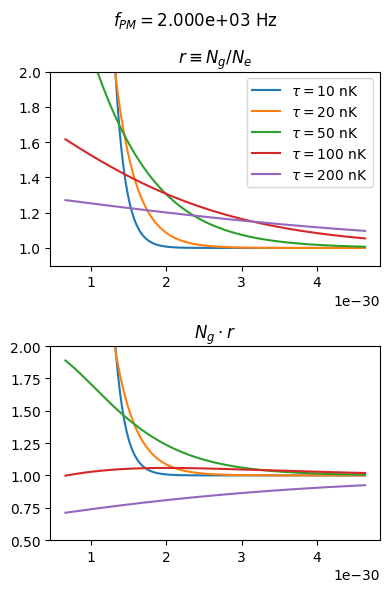

In [10]:
E_PM = f_Hz_PM * E9c.hnobar # energy difference between the two states
tau_list = T_nK_list * 1e-9 * E9c.k_B
mu_chem = np.arange(1e3, 7e3) * E9c.hnobar
fig_pop_rat = plt.figure(figsize = (4, 6))
ax_pop_rat = fig_pop_rat.add_subplot(2, 1, 1)
ax_sig = fig_pop_rat.add_subplot(2, 1, 2)

for T_nK, tau in zip(T_nK_list, tau_list):
    pop_ratio = util.fermi_stat(0, tau, mu_chem) / util.fermi_stat(E_PM, tau, mu_chem)
    signal_strength = pop_ratio * util.fermi_stat(0, tau, mu_chem)
    ax_pop_rat.plot(mu_chem, pop_ratio, label = (r"$\tau = $" f"{T_nK:d} nK"))
    ax_sig.plot(mu_chem, signal_strength)

ax_pop_rat.legend()
ax_pop_rat.set_title(r"$r \equiv N_g / N_e$")
ax_pop_rat.set_ylim(0.9, 2)
ax_sig.set_title(r"$N_g \cdot r$")
ax_sig.set_ylim(0.5, 2)
fig_pop_rat.suptitle((r"$f_{PM} =$" f"{f_Hz_PM:.3e} Hz"))
fig_pop_rat.tight_layout()

# Finite time considerations
## Inputs

In [11]:
t_halfpulse = 0.5e-3
t_ramp = 0.15e-3
bool_ramp_down = True
f_Hz_PM = 4e3               # frequency of the drive
N_phase_init = 4            # number of initial phases of PM to look at
phase_init = np.pi          # phase at t = -t_halfpulse, chosen to match the experiment

t_fft = 0.05                # time window that sets the frequency space resolution
f_halfwidth_plot = 3e3      # frequency window used in plots

## Initialization

In [12]:
dt = 1e-6 # use something commensurate to make sure that fft works properly
t_range_zeros1 = np.arange(-t_fft, -t_halfpulse, dt)
t_range_ramp_up = np.arange(-t_halfpulse, t_ramp - t_halfpulse, dt)
t_range_const = np.arange(t_ramp - t_halfpulse, t_halfpulse - t_ramp, dt)
t_range_ramp_down = np.arange(t_halfpulse - t_ramp, t_halfpulse, dt)
t_range_zeros2 = np.arange(t_halfpulse, t_fft, dt)

t_range_pulse = np.hstack([t_range_ramp_up, t_range_const, t_range_ramp_down])
t_range_all = np.hstack([t_range_zeros1, t_range_ramp_up, t_range_const, t_range_ramp_down, t_range_zeros2])
N_t_pts = len(t_range_all)

phase_t0 = phase_init - 2 * np.pi * t_halfpulse * f_Hz_PM  # phase at t = 0 if phi = 0

In [13]:
def lin_ramp(start, stop, t_range):
    frac = (t_range - t_range[0]) / (t_range[-1] - t_range[0])
    return start * (1 - frac) + stop * frac

def sine_ramp(start, stop, t_range):
    frac = (t_range - t_range[0]) / (t_range[-1] - t_range[0])
    ratio = (np.sin((frac - 1 / 2) * np.pi) + 1) / 2
    return start * (1 - ratio) + stop * ratio

all_ramps = {"linear": lin_ramp,
             "sinusoidal": sine_ramp}

## Fourier transform

Text(0.5, 1.0, 'velocity (arb. unit)')

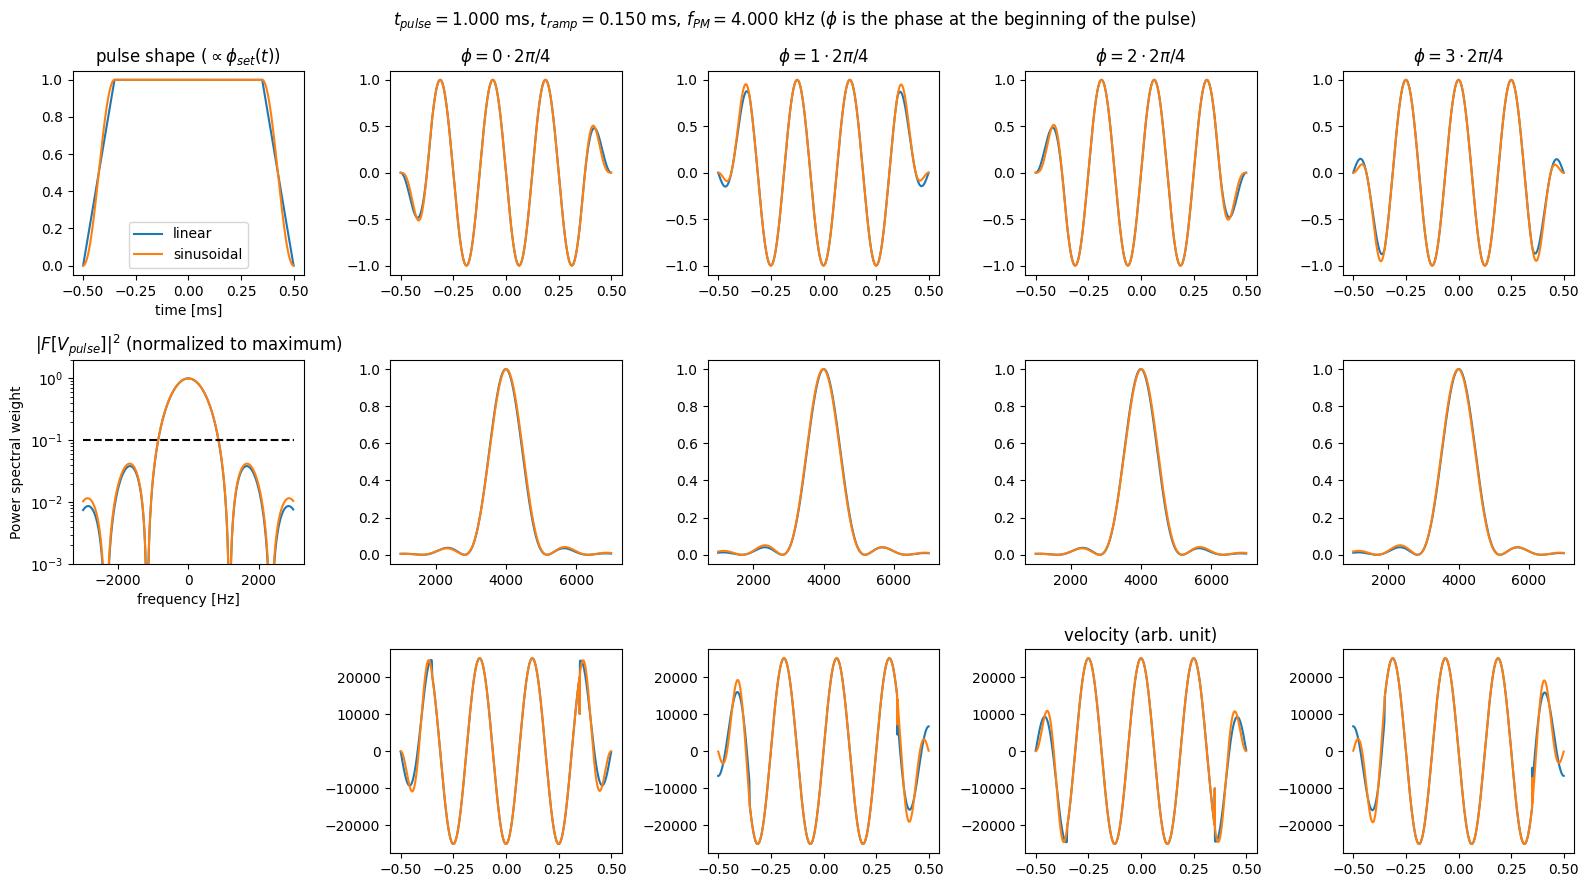

In [14]:
from scipy.fft import fft, fftshift, fftfreq

N_plt_col = 1 + N_phase_init
fig_env = plt.figure(figsize = ((1 + 3 * N_plt_col), 9))
ax_env_time = fig_env.add_subplot(3, N_plt_col, 1)
ax_env_freq = fig_env.add_subplot(3, N_plt_col, 1 + N_plt_col)
axes_pul = [fig_env.add_subplot(3, N_plt_col, 2 + i_ph) for i_ph in range(N_phase_init)]
axes_pul_freq = [fig_env.add_subplot(3, N_plt_col, 2 + N_plt_col + i_ph) for i_ph in range(N_phase_init)]
axes_pul_vel = [fig_env.add_subplot(3, N_plt_col, 2 + 2 * N_plt_col + i_ph) for i_ph in range(N_phase_init)]
f_axis = fftshift(fftfreq(N_t_pts, dt))

if1_env = abs(f_axis + f_halfwidth_plot).argmin()
if2_env = abs(f_axis - f_halfwidth_plot).argmin()
if1_pul = abs(f_axis - f_Hz_PM + f_halfwidth_plot).argmin()
if2_pul = abs(f_axis - f_Hz_PM - f_halfwidth_plot).argmin()
for ramp_name, ramp_fn in all_ramps.items():
    if bool_ramp_down:
        envelope = np.hstack([
        ramp_fn(0, 1, t_range_ramp_up),
        np.ones_like(t_range_const),
        ramp_fn(1, 0, t_range_ramp_down),
    ])
    else:
        envelope = np.hstack([
            ramp_fn(0, 1, t_range_ramp_up),
            np.ones_like(t_range_const),
            np.ones_like(t_range_ramp_down),
        ])
    ax_env_time.plot(t_range_pulse * 1e3, envelope, label = ramp_name)

    envelope_padded = np.hstack([
        np.zeros_like(t_range_zeros1),
        envelope, 
        np.zeros_like(t_range_zeros2),
    ])
    fft_pwr_envelope = abs(fftshift(fft(envelope_padded)))**2
    fft_pwr_envelope = fft_pwr_envelope / max(fft_pwr_envelope)
    ax_env_freq.plot(f_axis[if1_env:if2_env], fft_pwr_envelope[if1_env:if2_env])

    for i_ph in range(N_phase_init):
        phi_PM = 2 * np.pi * (i_ph / N_phase_init) + phase_t0
        pulse = envelope * np.sin(2 * np.pi * t_range_pulse * f_Hz_PM + phi_PM)
        axes_pul[i_ph].plot(t_range_pulse * 1e3, pulse)
        axes_pul[i_ph].set_title(rf"$\phi = {{{i_ph}}} \cdot 2 \pi / {{{N_phase_init}}}$")

        pulse_padded = envelope_padded * np.sin(2 * np.pi * t_range_all * f_Hz_PM + phi_PM)
        fft_pwr_pulse = abs(fftshift(fft(pulse_padded)))**2
        fft_pwr_pulse = fft_pwr_pulse / max(fft_pwr_pulse)
        axes_pul_freq[i_ph].plot(f_axis[if1_pul:if2_pul], fft_pwr_pulse[if1_pul:if2_pul])

        velocity = util.find_derivative(pulse, dt)
        axes_pul_vel[i_ph].plot(t_range_pulse * 1e3, velocity)

ax_env_time.legend()
ax_env_time.set_title(("pulse shape (" r"$\propto \phi_{set}(t)$" ")"))
ax_env_time.set_xlabel("time [ms]")

ax_env_freq.hlines([0.1], [f_axis[if1_env]], [f_axis[if2_env]], color = "k", linestyles = ["--"])
ax_env_freq.set_title(r"$|F[V_{pulse}]|^2$ (normalized to maximum)")
ax_env_freq.set_xlabel("frequency [Hz]")
ax_env_freq.set_yscale("log")
ax_env_freq.set_ylim(1e-3, 2)
ax_env_freq.set_ylabel("Power spectral weight")

fig_env.suptitle((r"$t_{pulse} =$" f"{t_halfpulse * 2 * 1e3:.3f} ms, " r"$t_{ramp} =$" f"{t_ramp * 1e3:.3f} ms, "
                  r"$f_{PM} =$" f"{f_Hz_PM / 1e3:.3f} kHz (" r"$\phi$" f" is the phase at the beginning of the pulse)"))
fig_env.tight_layout()

axes_pul_vel[int(N_phase_init / 2)].set_title("velocity (arb. unit)")

## Excitation probabilities
This section mainly looks at the time dependence of excitation probabilities for short pulses and does not include any information about the matrix element.

Ramp is not considered in this calculation.

In [15]:
# +101. to avoid zero division error
# Try to avoid very commensurate intervals
f_Hz_E_gaps = np.linspace(1.7e3, 6.5e3) + 101.
bool_RWA = False

C:\Users\ken92\AppData\Local\Temp\ipykernel_11756\639580270.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  img_ex = ax_ex.pcolormesh(t_pulse_from0 * 1e3, f_Hz_E_gaps, p_ex_arb)


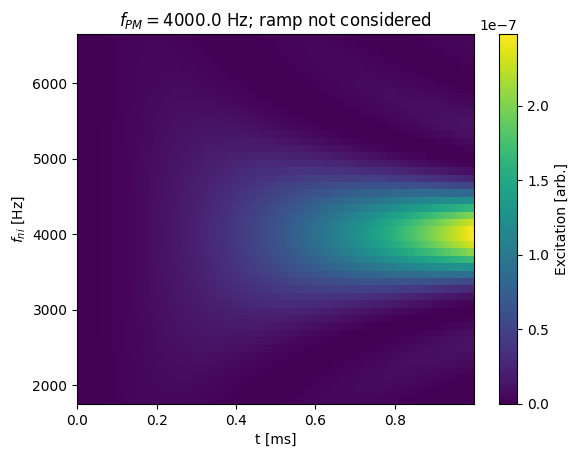

In [16]:
t_pulse_from0 = t_range_pulse - t_range_pulse[0]
d_omega = (f_Hz_E_gaps - f_Hz_PM) * 2 * np.pi
p_ex_arb = np.sin(d_omega[:, np.newaxis] * t_pulse_from0[np.newaxis, :] / 2)**2 / d_omega[:, np.newaxis]**2 # only on resonance term (RWA)

# sum_omega = (f_Hz_E_gaps + f_Hz_PM) * 2 * np.pi
# p_ex_arb += (np.sin(sum_omega[:, np.newaxis] * t_pulse_from0[np.newaxis, :] / 2)**2 / sum_omega[:, np.newaxis]**2
#              + np.sin(sum_omega[:, np.newaxis] * t_pulse_from0[np.newaxis, :] / 2) * np.sin(d_omega[:, np.newaxis] * t_pulse_from0[np.newaxis, :] / 2)
#                / (sum_omega * d_omega)[:, np.newaxis])

fig_ex = plt.figure()
ax_ex = fig_ex.add_subplot(1, 1, 1)
img_ex = ax_ex.pcolormesh(t_pulse_from0 * 1e3, f_Hz_E_gaps, p_ex_arb)
ax_ex.set_title((r"$f_{PM} =$" f"{f_Hz_PM:.1f} Hz; ramp not considered"))
ax_ex.set_xlabel("t [ms]")
ax_ex.set_ylabel((r"$f_{ni}$" " [Hz]"))
cbar_ex = fig_ex.colorbar(img_ex, ax = ax_ex)
cbar_ex.set_label("Excitation [arb.]")

# Absorption imaging related
Assuming high saturation for now.

## Random walk during absorption pulse

In [17]:
t_abs = 80e-6
s0_abs = 0.15

In [18]:
Gamma_K40_abs = E9ct.Gamma_scat(s0_abs, 0, E9c.gamma_K40_D2)
N_photon_K40_abs = Gamma_K40_abs / (2 * np.pi) * t_abs
v_z_K40_abs = E9c.v_r767_K40 * N_photon_K40_abs
r_z_K40_abs = v_z_K40_abs * t_abs / 2
r_rms_K40_abs = np.sqrt(N_photon_K40_abs / 3) * E9c.v_r767_K40 * t_abs
f_Hz_delta_K40_abs = v_z_K40_abs / E9c.c_light * E9c.nu_K40_4_2P3o2
delta_in_gamma_K40_abs = f_Hz_delta_K40_abs / (E9c.gamma_K40_D2 / (2 * np.pi))

Gamma_Rb87_abs = E9ct.Gamma_scat(s0_abs, 0, E9c.gamma_Rb87_D2)
N_photon_Rb87_abs = Gamma_Rb87_abs / (2 * np.pi) * t_abs
v_z_Rb87_abs = E9c.v_r780_Rb87 * N_photon_Rb87_abs
r_z_Rb87_abs = v_z_Rb87_abs * t_abs / 2
r_rms_Rb87_abs = np.sqrt(N_photon_Rb87_abs / 3) * E9c.v_r780_Rb87 * t_abs
f_Hz_delta_Rb87_abs = v_z_Rb87_abs / E9c.c_light * E9c.nu_Rb87_5_2P3o2
delta_in_gamma_Rb87_abs = f_Hz_delta_Rb87_abs / (E9c.gamma_Rb87_D2 / (2 * np.pi))

print(f"imaging pulse duration:         {t_abs / 1e-6:.2f} us")
print(f"Imaging beam intensity (s0):    {s0_abs:.2f}")
print( "                                            K40       Rb87")
print(f"Scattering rate:                            {Gamma_K40_abs / E9c.gamma_K40_D2:<10.4f}{Gamma_Rb87_abs / E9c.gamma_Rb87_D2:<10.4f} gamma")
print(f"Number of photons scattered by each atom:   {N_photon_K40_abs:<10.4f}{N_photon_Rb87_abs:<10.4f}")
print(f"Velocity along the imaging beam at the end: {v_z_K40_abs:<10.4f}{v_z_Rb87_abs:<10.4f} m/s")
print(f"Displacement along the imaging beam:        {r_z_K40_abs / 1e-6:<10.4f}{r_z_Rb87_abs / 1e-6:<10.4f} um")
print(f"rms displacement from random walk:          {r_rms_K40_abs / 1e-6:<10.4f}{r_rms_Rb87_abs / 1e-6:<10.4f} um")
print(f"Doppler shift at the end:                   {delta_in_gamma_K40_abs:<10.4f}{delta_in_gamma_Rb87_abs:<10.4f} gamma")

imaging pulse duration:         80.00 us
Imaging beam intensity (s0):    0.15
                                            K40       Rb87
Scattering rate:                            0.0652    0.0652     gamma
Number of photons scattered by each atom:   31.4870   31.6518   
Velocity along the imaging beam at the end: 0.4101    0.1863     m/s
Displacement along the imaging beam:        16.4022   7.4503     um
rms displacement from random walk:          3.3753    1.5291     um
Doppler shift at the end:                   0.0886    0.0393     gamma


## Depth of view
The depth of view is given by
$\frac{\lambda n}{NA^2} + \frac{n}{M \cdot NA} D_c$
, where $n = 1$ is the refraction index.

$D_c$ is the "maximum acceptable circle of confusion" diameter. For now I will take this to be the pixel size of our imaging system. I will say that the effect of depth of view is ignorable if $DOF \gg l_{atom, z}$.

In [19]:
f_obj = 150e-3  # I think
r_obj = 25.4e-3
l_px_atom_plane = 8.3e-6 / 2.19

In [20]:
NA_obj = np.sin(np.arctan(r_obj / f_obj))
print(NA_obj)
print(E9c.lambda_K40_D2 / NA_obj**2)
print(l_px_atom_plane / NA_obj)

0.16695661192292166
2.750544018851202e-05
2.270023507454284e-05


In [21]:
util.rayleigh_range(E9c.lambda_K40_D2, l_px_atom_plane)

5.885616793735109e-05

Since $DOF$ is actually comparable to the extension of the atom cloud in the $z$-direction, we must be somewhat careful and determine the spread due to the finite $DOF$. This can be done by applying the thin lens equation twice. (Need to check myself, but apparently) the dependence on the lens separation $L$ drops out to first order in the vertical displacement $\Delta z$, and from a purely geometrical optics point of view the *radius* of the blur in the *image plane* is simply given by
$$r_{img} = NA \Delta z$$
I expect this geometrical optics argument to be a good approximation if this is much larger than the diffraction limited spot size.

I am going to take $\Delta z$ to be the measured cloud lateral radius for a 14 ms time of flight, since for a non-interacting Fermi gas the profile should be exactly like a thermal cloud (for long time of flights; at t = 0 we have a TF like profile with a power of 3/2). We are not really in the long ToF regime ($t_{ToF}$ is probably comparable to $2 \pi / \omega_z$) so this is a rough approximation.

In [30]:
Dz_therm = 40e-6    # Check an actual run with single scan analysis when I have access

This turns out to be a larger factor than the rms displacement during absorption imaging pulse.

In [31]:
r_img_Dz = NA_obj * Dz_therm
print(r_img_Dz)
r_diff_lim = 1.22 * E9c.lambda_K40_D2 / 2 / NA_obj
print(r_diff_lim)
rl_diff_lim = util.rayleigh_range(E9c.lambda_K40_D2, r_diff_lim)
print(rl_diff_lim)
print(r_diff_lim * np.sqrt(2) * (Dz_therm / rl_diff_lim))

6.678264476916867e-06
2.801251213026746e-06
3.21534917336366e-05
4.928320059164474e-06


As a sanity check, let's look at the blur in the *image* plane (need to multiply by the magnification) due to free fall. This seems a bit too large.

In [32]:
2.19 * 1/2 * E9c.g_earth * 5e-3**2 / 1e-6

268.27500000000003

## Putting everything together
I will just find the rms sum of all the factors we consider.

In [33]:
print(np.sqrt(r_img_Dz**2 + r_rms_K40_abs**2))

7.482751959765796e-06
